In [1]:
# cd /Volumes/Shared/data/Jack/SavageLab/scripts/

In [3]:
cd /Users/jackdesmarais/Documents/berkeley/SavageLab/scripts

/Users/jackdesmarais/Documents/berkeley/SavageLab/scripts


In [7]:
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

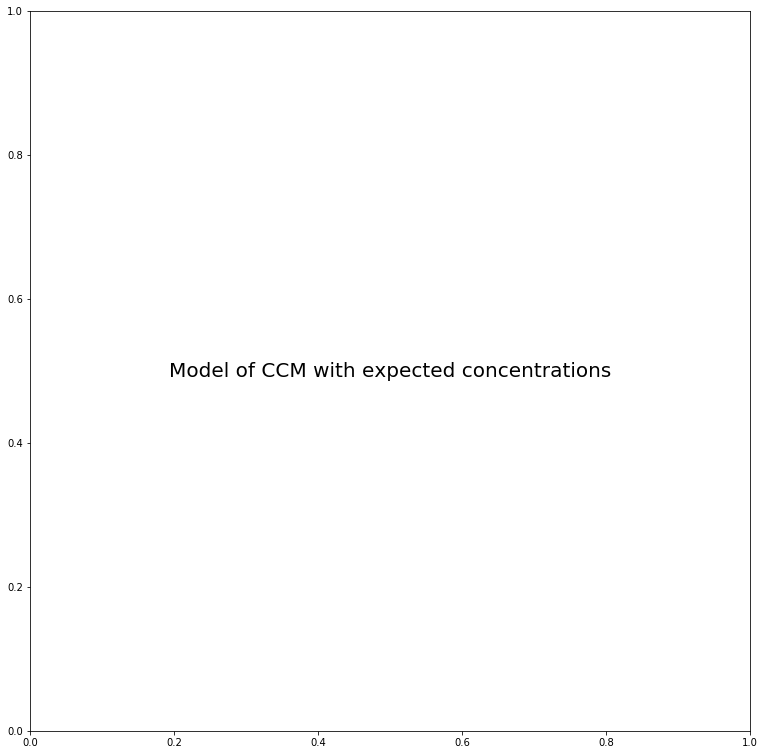

In [3]:
# Making Panel A
%matplotlib inline
def makePanelA(ax):
    ax.text(0.5,0.5,'Model of CCM with expected concentrations',va='center',ha='center',fontsize=20)
    

fig = plt.figure(figsize=(10,10),frameon=False)
ax=fig.add_axes([0,0,1,1])
makePanelA(ax)
plt.show()

In [10]:
import pylab

In [12]:
pylab

AttributeError: 'module' object has no attribute 'plot'

H2CO3 pKas (I = 0)
pKa1 = 3.43
pKa2 = 10.33
pKa_eff = 6.37

H2CO3 pKas (I = 0.20 [M])
pKa1 = 3.16
pKa2 = 9.80
pKa_eff = 6.10

H2CO3 pKas (I = 0.05 [M])
pKa1 = 3.26
pKa2 = 10.00
pKa_eff = 6.20

Formation energy of CO2_total at pH 7, I = 0.05 [M]
-546.84 kJ/mol

Aqueous gas concentrations at equilibrium
[CO2] = 13.6 uM
[O2] = 273.0 uM


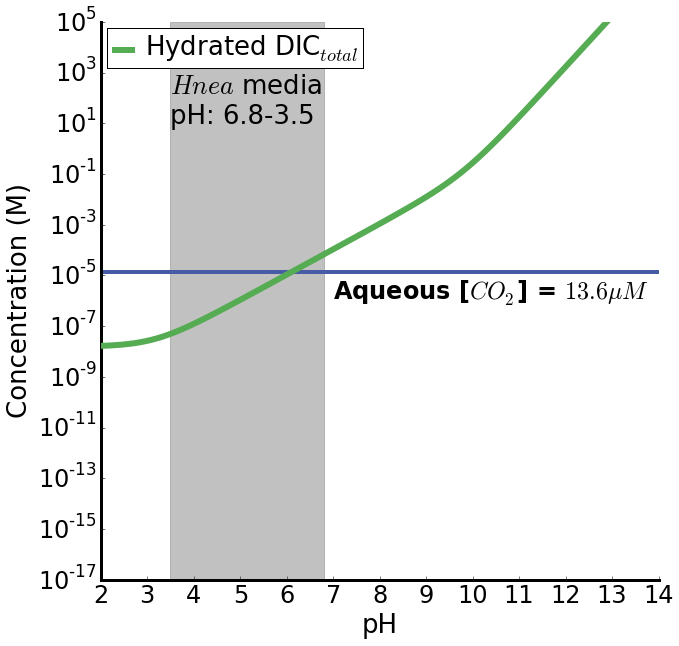

In [31]:
# Making Panel B
%matplotlib inline
def makePanelB(ax):
    import numpy as np
    import matplotlib.pyplot as pylab
    from scipy.special import logsumexp
    from numpy import log, exp, linspace, matrix
    
    import seaborn as sns
    cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
            ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
    colors = sns.color_palette(cols)
    vCol=colors[0]
    iCol=colors[2]
    eCol=colors[0] # hdic total
    nCol=colors[11] #hnea range
    acol=colors[6] #co2
    
    
    dG0_H2OdG0_H2O = -237.2 # kJ/mol
    R = 8.31e-3 # kJ/(K*mol)
    T = 298.15 # K

    # Standard formation energies for every specie. Data from Alberty (2003). 
    Alberty = {'CO2(g)':    {'nH':0, 'z':0,  'dG0_f': -394.36},
               'CO2(sp)':   {'nH':0, 'z':0,  'dG0_f': -385.97},
               'CO2(aq)':   {'nH':2, 'z':0,  'dG0_f': -385.97 - 237.13},
               'H2O(l)':    {'nH':2, 'z':0,  'dG0_f': -237.13},
               'H2CO3(sp)': {'nH':2, 'z':0,  'dG0_f': -606.33},
               'HCO3-(sp)': {'nH':1, 'z':-1, 'dG0_f': -586.77},
               'CO3-2(sp)': {'nH':0, 'z':-2, 'dG0_f': -527.81}}

    # Pretty LaTeX style names for captions. 
    PrettyNames = {'CO2(g)': r'$CO_2 Gas$',
                   'CO2(sp)': r'$Aqueous CO_2$',
                   'CO2(aq)': r'$Aqueous CO_2 + H_2O$',
                   'H2O(l)': r'$H_20$',
                   'H2CO3(sp)': r'$H_2CO_3$',
                   'HCO3-(sp)': r'$HCO_3^-$',
                   'CO3-2(sp)': r'$CO_3^{2-}$'}

    # Mapping of KEGG IDs to protonation states of particular chemical species.
    # Protonations states (AKA pseudoisomers) assumed to be in equilibrium with pH.
    KEGG2sp = {'C00288': ['H2CO3(sp)', 'HCO3-(sp)', 'CO3-2(sp)'], # H_total
               'C00001': ['H2O(l)'],
               'C00011': ['CO2(sp)'],
               'C99998': ['CO2(aq)']} # False KEGG ID for CO2 + H2O
    # Debye-Huckel
    # Approximation of the temperature dependency of ionic strength effects
    DH_alpha = 1e-3*(9.20483*T) - 1e-5*(1.284668 * T**2) + 1e-8*(4.95199 * T**3)
    DH_beta = 1.6
    def debye_huckel(I):
        """Approximation of the temperature dependency of ionic strength effects."""
        return DH_alpha * I**(0.5) / (1.0 + DH_beta * I**(0.5))

    def transform(species, pH, I):
        """Calculates the dG' for the species group.

        Calculates a single formation energy for the entire group,
        transforming to account for the effect of pH and ionic strength
        at the absolute temperature specified above.

        Args:
            species: the identified for the group of species.
            pH: the pH.
            I: the ionic strength, molar units.
        """ 
        DH = debye_huckel(I)
        dG0_primes = []
        for d in map(Alberty.get, species):
            dG0_prime = d['dG0_f'] + \
                        d['nH'] * (R*T*log(10)*pH + DH) - \
                        d['z']**2 * DH
            dG0_primes.append(dG0_prime)
        dG0_prime_tot = -R*T * logsumexp([-x/(R*T) for x in dG0_primes])

        P = map(lambda x: exp((dG0_prime_tot - x)/(R*T)), dG0_primes)
        return dG0_prime_tot, dict(zip(species, P))

    def calc_dG0_prime(sparse, pH, I):
        dG0_prime = 0
        for kegg_id, coeff in sparse.items():
            dG0_prime += coeff * transform(KEGG2sp[kegg_id], pH, I)[0]
        return dG0_prime
    
    # Calculate the pKas from dGf without DH correction for ionic strength.
    h2co3_d   = Alberty['H2CO3(sp)']
    hco3_d    = Alberty['HCO3-(sp)']
    co3_d     = Alberty['CO3-2(sp)']
    co2aq_d   = Alberty['CO2(aq)']
    dGf_h2co3 = h2co3_d['dG0_f']
    dGf_hco3  = hco3_d['dG0_f']
    dGf_co3   = co3_d['dG0_f']
    dGf_co2aq = co2aq_d['dG0_f']

    pKa1 = (dGf_hco3 - dGf_h2co3) / (R*T*log(10))
    pKa2 = (dGf_co3 - dGf_hco3) / (R*T*log(10))
    pKa_eff = (dGf_hco3 - dGf_co2aq) / (R*T*log(10))
    print('H2CO3 pKas (I = 0)')
    print('pKa1 = %.2f' % pKa1)
    print('pKa2 = %.2f' % pKa2)
    print('pKa_eff = %.2f' % pKa_eff)
    print()

    # Calculate the pKas from dGf WITH DH correction for ionic strength.
    ionic_s = .2 # in [M]
    DH = debye_huckel(ionic_s)
    dGf_h2co3_I = dGf_h2co3 + h2co3_d['nH'] * DH - h2co3_d['z']**2 * DH  # nH = 2, z = 0
    dGf_hco3_I  = dGf_hco3  + hco3_d['nH']  * DH - hco3_d['z'] **2 * DH  # nH = 1, z = -1
    dGf_co3_I   = dGf_co3   + co3_d['nH']   * DH - co3_d['z']  **2 * DH  # nH = 0, z = -2
    dGf_co2aq_I = dGf_co2aq + co2aq_d['nH'] * DH - co2aq_d['z']**2 * DH  # nH = 0, z = 0

    pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))
    pKa2 = (dGf_co3_I - dGf_hco3_I) / (R*T*log(10))
    pKa_eff = (dGf_hco3_I - dGf_co2aq_I) / (R*T*log(10))
    print('H2CO3 pKas (I = %.2f [M])' % ionic_s)
    print('pKa1 = %.2f' % pKa1)
    print('pKa2 = %.2f' % pKa2)
    print('pKa_eff = %.2f' % pKa_eff)
    print()

    ionic_s = .05 # in [M]
    DH = debye_huckel(ionic_s)
    dGf_h2co3_I = dGf_h2co3 + h2co3_d['nH'] * DH - h2co3_d['z']**2 * DH  # nH = 2, z = 0
    dGf_hco3_I  = dGf_hco3  + hco3_d['nH']  * DH - hco3_d['z'] **2 * DH  # nH = 1, z = -1
    dGf_co3_I   = dGf_co3   + co3_d['nH']   * DH - co3_d['z']  **2 * DH  # nH = 0, z = -2
    dGf_co2aq_I = dGf_co2aq + co2aq_d['nH'] * DH - co2aq_d['z']**2 * DH  # nH = 0, z = 0

    pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))
    pKa2 = (dGf_co3_I - dGf_hco3_I) / (R*T*log(10))
    pKa_eff = (dGf_hco3_I - dGf_co2aq_I) / (R*T*log(10))
    print('H2CO3 pKas (I = %.2f [M])' % ionic_s)
    print('pKa1 = %.2f' % pKa1)
    print('pKa2 = %.2f' % pKa2)
    print('pKa_eff = %.2f' % pKa_eff)
    print()

    # assert that the acid and base have equal dG'0 in the calculated pKa:
    np.testing.assert_almost_equal(transform(['HCO3-(sp)'], pKa1, ionic_s)[0],
                                   transform(['H2CO3(sp)'], pKa1, ionic_s)[0])
    np.testing.assert_almost_equal(transform(['CO3-2(sp)'], pKa2, ionic_s)[0],
                                   transform(['HCO3-(sp)'], pKa2, ionic_s)[0])
    np.testing.assert_almost_equal(transform(['CO2(aq)'],   pKa_eff, ionic_s)[0],
                                   transform(['HCO3-(sp)'], pKa_eff, ionic_s)[0])

    # Calculate dGr at specified pH and I
    print('Formation energy of CO2_total at pH 7, I = %.2f [M]' % ionic_s)
    print('%.2f kJ/mol' % transform(KEGG2sp['C00288'], 7, ionic_s)[0])
    print()
    
    # Plot the pH dependence of the mole fraction of species in H_total.
    data = []
    pH_range = linspace(2, 14, 100)
    species = KEGG2sp['C00288']
    pretty_species = [PrettyNames[k] for k in species]
    for pH in pH_range:
        dG0_prime, P_dict = transform(species, pH, 0.2)
        ordered_vals = [P_dict[k] for k in species]
        data.append(ordered_vals)

    fractional_abundance = matrix(data)

    
    


    
    # Partial pressures of CO2 and O2.# Parti 
    co2_pp = 400e-6
    o2_pp = 0.21

    # Solubility coefficients.
    co2_solubility = 29.41 # L·atm/mol
    o2_solubility = 769.2 # L·atm/mol

    # Aqueous concentration when in equilibrium with the atmosphere.
    co2_conc = co2_pp / co2_solubility
    o2_conc = o2_pp / o2_solubility

    print('Aqueous gas concentrations at equilibrium')
    print('[CO2] = %.1f uM' % (co2_conc * 1e6))
    print('[O2] = %.1f uM' % (o2_conc * 1e6))
    
    # Plot the equilibrium concentration of dissolved inorganic carbon assuming
    # that CO2 equilibrates with the atmosphere and then with H_total accoring to the pH. 
    # I = 0.2 is towards the top of the biological range according to BNID 107522. 
    I = 0.2
    sparse = {'C00001': -1, 'C00011': -1, 'C00288': 1}  # Hydration of CO2 to H_total. 

    pH_resp_dg = np.zeros(pH_range.size)
    for i, pH in enumerate(pH_range):
        pH_resp_dg[i] = calc_dG0_prime(sparse, pH, I)

    # Calculate the keq from dGr and then pH-dependence of Htotal conc.
    keq = np.exp(-pH_resp_dg / (R*T))
    h_total = keq * co2_conc
    # Concentrations of H_total species follow mole fractions calculated above.
    species_conc = np.multiply(fractional_abundance.T, h_total).T

#     pylab.semilogy(pH_range, species_conc[:,0], lw=4, zorder=5,color=iCol)
#     pylab.semilogy(pH_range, species_conc[:,1], lw=4, zorder=5,color=eCol)
#     pylab.semilogy(pH_range, species_conc[:,2], lw=4, zorder=5,color=nCol)

    pylab.semilogy(pH_range, h_total, lw=6, ls='-', zorder=10,color=eCol)
#     pylab.semilogy([3,6.8],[1e1,1e1],lw=6, ls='-', zorder=10,color=nCol)
    pylab.axvspan(3.5,6.8, zorder=0,color=nCol,alpha=0.5)


    pylab.semilogy(pH_range, np.ones(pH_range.size) * co2_conc, lw=4, zorder=1, color=acol)
#     pylab.semilogy(pH_range, np.ones(pH_range.size) * o2_conc, lw=4, zorder=1)

    # Label exact concentrations of aqueous gasses on the plot. 
    pylab.text(7, 0.08 * co2_conc, 'Aqueous [$CO_2$] = $%.1f {\mu}M$' % (co2_conc * 1e6),
               fontsize=24, fontweight='bold')
    pylab.text(3.5, 1e1, '$Hnea$ media\npH: 6.8-3.5',
               fontsize=26)
#     pylab.text(10.5, 1.8 * o2_conc, 'Aqueous [$O_2$] = $%.1f {\mu}M$' % (o2_conc * 1e6),
#                fontsize=13, fontweight='bold')

    # Labels for species in H_total
    pretty_species_conc = ['[%s]' % ps for ps in pretty_species]
#     labels = pretty_species_conc #+ [r'$DIC_{total}$']
    labels = [r'Hydrated DIC$_{total}$']#,r'$H.neapolitanus$ media pH range']

    
#     pylab.axvline(x=6.8,c=vCol)
#     pylab.axvline(x=3,c=vCol)


    pylab.legend(labels, loc=2)
    leg = pylab.gca().get_legend()
    ltext  = leg.get_texts()
    pylab.setp(ltext, fontsize=26)
    
            # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
#     change axis weight
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

    pylab.xlabel('pH', fontsize=26)
    pylab.ylabel('Concentration (M)', fontsize=26)
    pylab.xlim((2, 12))
    pylab.ylim((1e-17, 1e5))
    pylab.xticks(np.arange(2,15), fontsize=24)
    pylab.yticks(fontsize=24)    
   
fig,ax = plt.subplots(figsize=(10,10), frameon=False)
makePanelB(ax)
plt.savefig('./FigureMakingForBarseqDABPaper/figsForPaper/fig5PanelA.eps',format='eps',bbox_inches='tight')

plt.show()

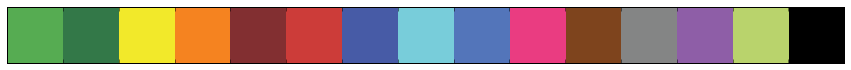

In [8]:
cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
        ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
colors = sns.color_palette(cols)
sns.palplot(colors)
plt.show()

H2CO3 pKas (I = 0)
pKa1 = 3.43
pKa2 = 10.33
pKa_eff = 6.37

H2CO3 pKas (I = 0.20 [M])
pKa1 = 3.16
pKa2 = 9.80
pKa_eff = 6.10

H2CO3 pKas (I = 0.05 [M])
pKa1 = 3.26
pKa2 = 10.00
pKa_eff = 6.20

Formation energy of CO2_total at pH 7, I = 0.05 [M]
-546.84 kJ/mol

Aqueous gas concentrations at equilibrium
[CO2] = 13.6 uM
[O2] = 273.0 uM


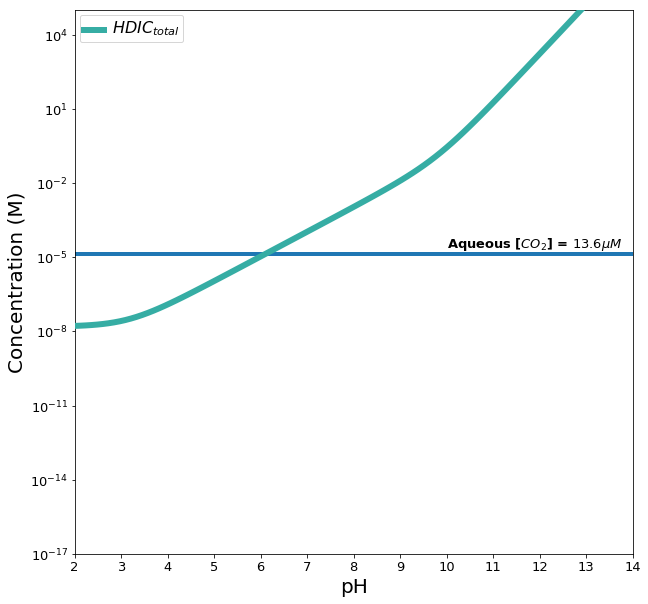

In [8]:
# Making Panel B
%matplotlib inline
def makePanel(ax):
    import numpy as np
    import pylab
    from scipy.special import logsumexp
    from numpy import log, exp, linspace, matrix
    
    import seaborn as sns
    colors=sns.color_palette('husl',8)
    vCol=colors[0]
    iCol=colors[2]
    eCol=colors[4]
    nCol=colors[7]
    aCol=colors[6]
    
    
    dG0_H2OdG0_H2O = -237.2 # kJ/mol
    R = 8.31e-3 # kJ/(K*mol)
    T = 298.15 # K

    # Standard formation energies for every specie. Data from Alberty (2003). 
    Alberty = {'CO2(g)':    {'nH':0, 'z':0,  'dG0_f': -394.36},
               'CO2(sp)':   {'nH':0, 'z':0,  'dG0_f': -385.97},
               'CO2(aq)':   {'nH':2, 'z':0,  'dG0_f': -385.97 - 237.13},
               'H2O(l)':    {'nH':2, 'z':0,  'dG0_f': -237.13},
               'H2CO3(sp)': {'nH':2, 'z':0,  'dG0_f': -606.33},
               'HCO3-(sp)': {'nH':1, 'z':-1, 'dG0_f': -586.77},
               'CO3-2(sp)': {'nH':0, 'z':-2, 'dG0_f': -527.81}}

    # Pretty LaTeX style names for captions. 
    PrettyNames = {'CO2(g)': r'$CO_2 Gas$',
                   'CO2(sp)': r'$Aqueous CO_2$',
                   'CO2(aq)': r'$Aqueous CO_2 + H_2O$',
                   'H2O(l)': r'$H_20$',
                   'H2CO3(sp)': r'$H_2CO_3$',
                   'HCO3-(sp)': r'$HCO_3^-$',
                   'CO3-2(sp)': r'$CO_3^{2-}$'}

    # Mapping of KEGG IDs to protonation states of particular chemical species.
    # Protonations states (AKA pseudoisomers) assumed to be in equilibrium with pH.
    KEGG2sp = {'C00288': ['H2CO3(sp)', 'HCO3-(sp)', 'CO3-2(sp)'], # H_total
               'C00001': ['H2O(l)'],
               'C00011': ['CO2(sp)'],
               'C99998': ['CO2(aq)']} # False KEGG ID for CO2 + H2O
    # Debye-Huckel
    # Approximation of the temperature dependency of ionic strength effects
    DH_alpha = 1e-3*(9.20483*T) - 1e-5*(1.284668 * T**2) + 1e-8*(4.95199 * T**3)
    DH_beta = 1.6
    def debye_huckel(I):
        """Approximation of the temperature dependency of ionic strength effects."""
        return DH_alpha * I**(0.5) / (1.0 + DH_beta * I**(0.5))

    def transform(species, pH, I):
        """Calculates the dG' for the species group.

        Calculates a single formation energy for the entire group,
        transforming to account for the effect of pH and ionic strength
        at the absolute temperature specified above.

        Args:
            species: the identified for the group of species.
            pH: the pH.
            I: the ionic strength, molar units.
        """ 
        DH = debye_huckel(I)
        dG0_primes = []
        for d in map(Alberty.get, species):
            dG0_prime = d['dG0_f'] + \
                        d['nH'] * (R*T*log(10)*pH + DH) - \
                        d['z']**2 * DH
            dG0_primes.append(dG0_prime)
        dG0_prime_tot = -R*T * logsumexp([-x/(R*T) for x in dG0_primes])

        P = map(lambda x: exp((dG0_prime_tot - x)/(R*T)), dG0_primes)
        return dG0_prime_tot, dict(zip(species, P))

    def calc_dG0_prime(sparse, pH, I):
        dG0_prime = 0
        for kegg_id, coeff in sparse.items():
            dG0_prime += coeff * transform(KEGG2sp[kegg_id], pH, I)[0]
        return dG0_prime
    
    # Calculate the pKas from dGf without DH correction for ionic strength.
    h2co3_d   = Alberty['H2CO3(sp)']
    hco3_d    = Alberty['HCO3-(sp)']
    co3_d     = Alberty['CO3-2(sp)']
    co2aq_d   = Alberty['CO2(aq)']
    dGf_h2co3 = h2co3_d['dG0_f']
    dGf_hco3  = hco3_d['dG0_f']
    dGf_co3   = co3_d['dG0_f']
    dGf_co2aq = co2aq_d['dG0_f']

    pKa1 = (dGf_hco3 - dGf_h2co3) / (R*T*log(10))
    pKa2 = (dGf_co3 - dGf_hco3) / (R*T*log(10))
    pKa_eff = (dGf_hco3 - dGf_co2aq) / (R*T*log(10))
    print('H2CO3 pKas (I = 0)')
    print('pKa1 = %.2f' % pKa1)
    print('pKa2 = %.2f' % pKa2)
    print('pKa_eff = %.2f' % pKa_eff)
    print()

    # Calculate the pKas from dGf WITH DH correction for ionic strength.
    ionic_s = .2 # in [M]
    DH = debye_huckel(ionic_s)
    dGf_h2co3_I = dGf_h2co3 + h2co3_d['nH'] * DH - h2co3_d['z']**2 * DH  # nH = 2, z = 0
    dGf_hco3_I  = dGf_hco3  + hco3_d['nH']  * DH - hco3_d['z'] **2 * DH  # nH = 1, z = -1
    dGf_co3_I   = dGf_co3   + co3_d['nH']   * DH - co3_d['z']  **2 * DH  # nH = 0, z = -2
    dGf_co2aq_I = dGf_co2aq + co2aq_d['nH'] * DH - co2aq_d['z']**2 * DH  # nH = 0, z = 0

    pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))
    pKa2 = (dGf_co3_I - dGf_hco3_I) / (R*T*log(10))
    pKa_eff = (dGf_hco3_I - dGf_co2aq_I) / (R*T*log(10))
    print('H2CO3 pKas (I = %.2f [M])' % ionic_s)
    print('pKa1 = %.2f' % pKa1)
    print('pKa2 = %.2f' % pKa2)
    print('pKa_eff = %.2f' % pKa_eff)
    print()

    ionic_s = .05 # in [M]
    DH = debye_huckel(ionic_s)
    dGf_h2co3_I = dGf_h2co3 + h2co3_d['nH'] * DH - h2co3_d['z']**2 * DH  # nH = 2, z = 0
    dGf_hco3_I  = dGf_hco3  + hco3_d['nH']  * DH - hco3_d['z'] **2 * DH  # nH = 1, z = -1
    dGf_co3_I   = dGf_co3   + co3_d['nH']   * DH - co3_d['z']  **2 * DH  # nH = 0, z = -2
    dGf_co2aq_I = dGf_co2aq + co2aq_d['nH'] * DH - co2aq_d['z']**2 * DH  # nH = 0, z = 0

    pKa1 = (dGf_hco3_I - dGf_h2co3_I) / (R*T*log(10))
    pKa2 = (dGf_co3_I - dGf_hco3_I) / (R*T*log(10))
    pKa_eff = (dGf_hco3_I - dGf_co2aq_I) / (R*T*log(10))
    print('H2CO3 pKas (I = %.2f [M])' % ionic_s)
    print('pKa1 = %.2f' % pKa1)
    print('pKa2 = %.2f' % pKa2)
    print('pKa_eff = %.2f' % pKa_eff)
    print()

    # assert that the acid and base have equal dG'0 in the calculated pKa:
    np.testing.assert_almost_equal(transform(['HCO3-(sp)'], pKa1, ionic_s)[0],
                                   transform(['H2CO3(sp)'], pKa1, ionic_s)[0])
    np.testing.assert_almost_equal(transform(['CO3-2(sp)'], pKa2, ionic_s)[0],
                                   transform(['HCO3-(sp)'], pKa2, ionic_s)[0])
    np.testing.assert_almost_equal(transform(['CO2(aq)'],   pKa_eff, ionic_s)[0],
                                   transform(['HCO3-(sp)'], pKa_eff, ionic_s)[0])

    # Calculate dGr at specified pH and I
    print('Formation energy of CO2_total at pH 7, I = %.2f [M]' % ionic_s)
    print('%.2f kJ/mol' % transform(KEGG2sp['C00288'], 7, ionic_s)[0])
    print()
    
    # Plot the pH dependence of the mole fraction of species in H_total.
    data = []
    pH_range = linspace(2, 14, 100)
    species = KEGG2sp['C00288']
    pretty_species = [PrettyNames[k] for k in species]
    for pH in pH_range:
        dG0_prime, P_dict = transform(species, pH, 0.2)
        ordered_vals = [P_dict[k] for k in species]
        data.append(ordered_vals)

    fractional_abundance = matrix(data)

    
    


    
    # Partial pressures of CO2 and O2.# Parti 
    co2_pp = 400e-6
    o2_pp = 0.21

    # Solubility coefficients.
    co2_solubility = 29.41 # L·atm/mol
    o2_solubility = 769.2 # L·atm/mol

    # Aqueous concentration when in equilibrium with the atmosphere.
    co2_conc = co2_pp / co2_solubility
    o2_conc = o2_pp / o2_solubility

    print('Aqueous gas concentrations at equilibrium')
    print('[CO2] = %.1f uM' % (co2_conc * 1e6))
    print('[O2] = %.1f uM' % (o2_conc * 1e6))
    
    # Plot the equilibrium concentration of dissolved inorganic carbon assuming
    # that CO2 equilibrates with the atmosphere and then with H_total accoring to the pH. 
    # I = 0.2 is towards the top of the biological range according to BNID 107522. 
    I = 0.2
    sparse = {'C00001': -1, 'C00011': -1, 'C00288': 1}  # Hydration of CO2 to H_total. 

    pH_resp_dg = np.zeros(pH_range.size)
    for i, pH in enumerate(pH_range):
        pH_resp_dg[i] = calc_dG0_prime(sparse, pH, I)

    # Calculate the keq from dGr and then pH-dependence of Htotal conc.
    keq = np.exp(-pH_resp_dg / (R*T))
    h_total = keq * co2_conc
    # Concentrations of H_total species follow mole fractions calculated above.
    species_conc = np.multiply(fractional_abundance.T, h_total).T

#     pylab.semilogy(pH_range, species_conc[:,0], lw=4, zorder=5,color=iCol)
#     pylab.semilogy(pH_range, species_conc[:,1], lw=4, zorder=5,color=eCol)
#     pylab.semilogy(pH_range, species_conc[:,2], lw=4, zorder=5,color=nCol)

    pylab.semilogy(pH_range, h_total, lw=6, ls='-', zorder=10,color=eCol)
    pylab.semilogy(pH_range, np.ones(pH_range.size) * co2_conc, lw=4, zorder=1)
#     pylab.semilogy(pH_range, np.ones(pH_range.size) * o2_conc, lw=4, zorder=1)

    # Label exact concentrations of aqueous gasses on the plot. 
    pylab.text(10, 1.8 * co2_conc, 'Aqueous [$CO_2$] = $%.1f {\mu}M$' % (co2_conc * 1e6),
               fontsize=13, fontweight='bold')
#     pylab.text(10.5, 1.8 * o2_conc, 'Aqueous [$O_2$] = $%.1f {\mu}M$' % (o2_conc * 1e6),
#                fontsize=13, fontweight='bold')

    # Labels for species in H_total
    pretty_species_conc = ['[%s]' % ps for ps in pretty_species]
    labels = [r'$HDIC_{total}$']

#     labels = pretty_species_conc #+ [r'$HDIC_{total}$']
    
#     pylab.axvline(x=6.8,c=vCol)
#     pylab.axvline(x=3,c=vCol)


    pylab.legend(labels, loc=2)
    leg = pylab.gca().get_legend()
    ltext  = leg.get_texts()
    pylab.setp(ltext, fontsize=16)

    pylab.xlabel('pH', fontsize=20)
    pylab.ylabel('Concentration (M)', fontsize=20)
    pylab.xlim((2, 12))
    pylab.ylim((1e-17, 1e5))
    pylab.xticks(np.arange(2,15), fontsize=13)
    pylab.yticks(fontsize=13)    
   
fig,ax = plt.subplots(figsize=(10,10), frameon=False)
makePanel(ax)
plt.show()

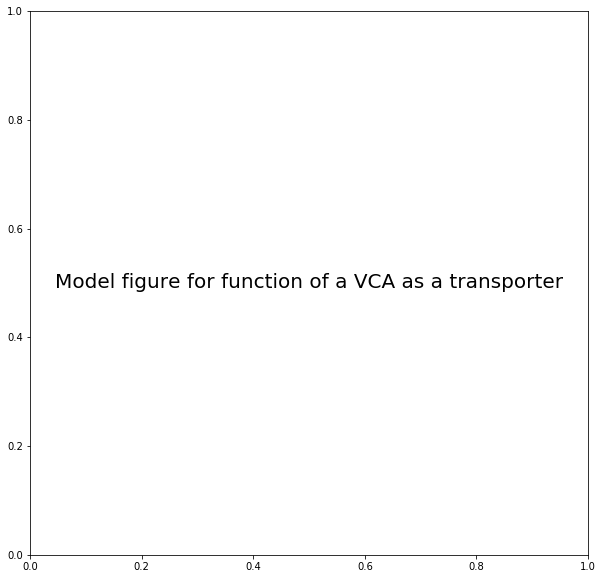

In [5]:
# Making Panel C
%matplotlib inline
def makePanelC(ax):
    import seaborn as sns
    colors=sns.color_palette('husl',8)
    aCol=colors[0]
    bCol=colors[5]
    
    ax.text(0.5,0.5,'Model figure for function of a VCA as a transporter',va='center',ha='center',fontsize=20)
#     width=0.05
#     head_width=0.085
#     head_scale=0.2
    
    
# #     Make DAB2
#     y=0.75
#     oplength=4185
#     opstart=7103
    
# #     make DAB2A (NDH)
#     geneStart=7103
#     geneLen=1656
#     x=geneStart-opstart
#     genLength= geneLen/oplength
#     dab2A = matplotlib.patches.FancyArrow(x,y,genLength,0,width=width,length_includes_head=True,
#                                           head_width=head_width, fill=True,facecolor=aCol,
#                                          head_length=genLength*head_scale)
#     ax.add_artist(dab2A)
#     plt.text(x+genLength/2,y+2*head_width,'DAB2A', size=18, ha='center', va='center',color="k", rotation=0)

# #     Make DAB2B (DUF)
#     geneStart=5402
#     geneLen=2404
#     x=(opstart-geneStart)/oplength
#     genLength= geneLen/oplength
#     dab2B = matplotlib.patches.FancyArrow(x,y,genLength,0,width=width,length_includes_head=True,
#                                           head_width=head_width, fill=True,facecolor=bCol,
#                                          head_length=genLength*head_scale)
#     ax.add_artist(dab2B)
#     plt.text(x+genLength/2,y+2*head_width,'DAB2B', size=18, ha='center', va='center',color="k", rotation=0)
    
# #     plot active site residues
#     loc=3832
#     x=(opstart-loc)/oplength
#     plt.annotate('*',[x,y],xytext=[x,y+head_width],arrowprops={'arrowstyle':'-'},ha='center')
    
#     loc=3787
#     x=(opstart-loc)/oplength
#     plt.annotate('*',[x,y],xytext=[x,y+head_width],arrowprops={'arrowstyle':'-'},ha='center')
    
#     loc=4351
#     x=(opstart-loc)/oplength
#     plt.annotate('*',[x,y],xytext=[x+0.01,y+head_width],arrowprops={'arrowstyle':'-'},ha='center')
    
#     loc=4345
#     x=(opstart-loc)/oplength
#     plt.annotate('*',[x,y],xytext=[x-0.01,y+head_width],arrowprops={'arrowstyle':'-'},ha='center')
    
    
#     #     Make DAB1
#     y=0.25
#     oplength=5573
#     opstart=8433
    
# #     make DAB1A (NDH)
#     geneStart=8433
#     geneLen=1680
#     x=geneStart-opstart
#     genLength= geneLen/oplength
#     dab2A = matplotlib.patches.FancyArrow(x,y,genLength,0,width=width,length_includes_head=True,
#                                           head_width=head_width, fill=True,facecolor=aCol,
#                                          head_length=genLength*head_scale)
#     ax.add_artist(dab2A)
#     plt.text(x+genLength/2,y+2*head_width,'DAB1A', size=18, ha='center', va='center',color="k", rotation=0)

# #     Make DAB1B (DUF)
#     geneStart=6752
#     geneLen=747
#     x=(opstart-geneStart)/oplength
#     genLength= geneLen/oplength
#     dab2B = matplotlib.patches.FancyArrow(x,y,genLength,0,width=width,length_includes_head=True,
#                                           head_width=head_width, fill=True,facecolor=aCol,
#                                          head_length=genLength*head_scale)
#     ax.add_artist(dab2B)
#     plt.text(x+genLength/2,y+2*head_width,'DAB1A2', size=18, ha='center', va='center',color="k", rotation=0)
    
#     #     Make DAB1C (DUF)
#     geneStart=6001
#     geneLen=3141
#     x=(opstart-geneStart)/oplength
#     genLength= geneLen/oplength
#     dab2B = matplotlib.patches.FancyArrow(x,y,genLength,0,width=width,length_includes_head=True,
#                                           head_width=head_width, fill=True,facecolor=bCol,
#                                          head_length=genLength*head_scale)
#     ax.add_artist(dab2B)
#     plt.text(x+genLength/2,y+2*head_width,'DAB1C', size=18, ha='center', va='center',color="k", rotation=0)
    
# #     plot active site residues
#     loc=4611
#     x=(opstart-loc)/oplength
#     plt.annotate('*',[x,y],xytext=[x+0.01,y+head_width],arrowprops={'arrowstyle':'-'},ha='center')
    
#     loc=4617
#     x=(opstart-loc)/oplength
#     plt.annotate('*',[x,y],xytext=[x-0.01,y+head_width],arrowprops={'arrowstyle':'-'},ha='center')
    
#     loc=3795
#     x=(opstart-loc)/oplength
#     plt.annotate('*',[x,y],xytext=[x,y+head_width],arrowprops={'arrowstyle':'-'},ha='center')
    
#     loc=3840
#     x=(opstart-loc)/oplength
#     plt.annotate('*',[x,y],xytext=[x,y+head_width],arrowprops={'arrowstyle':'-'},ha='center')
    
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
#     plt.text(geneRegion.loc[gene,'begin']+(geneRegion.loc[gene,'length']*0.8)/2,-5,geneRegion.loc[gene,'sysName'], size=18, ha='center', va='center',color="k", rotation=90)
fig,ax = plt.subplots(figsize=(10,10), frameon=False)
makePanelC(ax)
plt.show()

H2CO3 pKas (I = 0)
pKa1 = 3.43
pKa2 = 10.33
pKa_eff = 6.37

H2CO3 pKas (I = 0.20 [M])
pKa1 = 3.16
pKa2 = 9.80
pKa_eff = 6.10

H2CO3 pKas (I = 0.05 [M])
pKa1 = 3.26
pKa2 = 10.00
pKa_eff = 6.20

Formation energy of CO2_total at pH 7, I = 0.05 [M]
-546.84 kJ/mol

Aqueous gas concentrations at equilibrium
[CO2] = 13.6 uM
[O2] = 273.0 uM


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


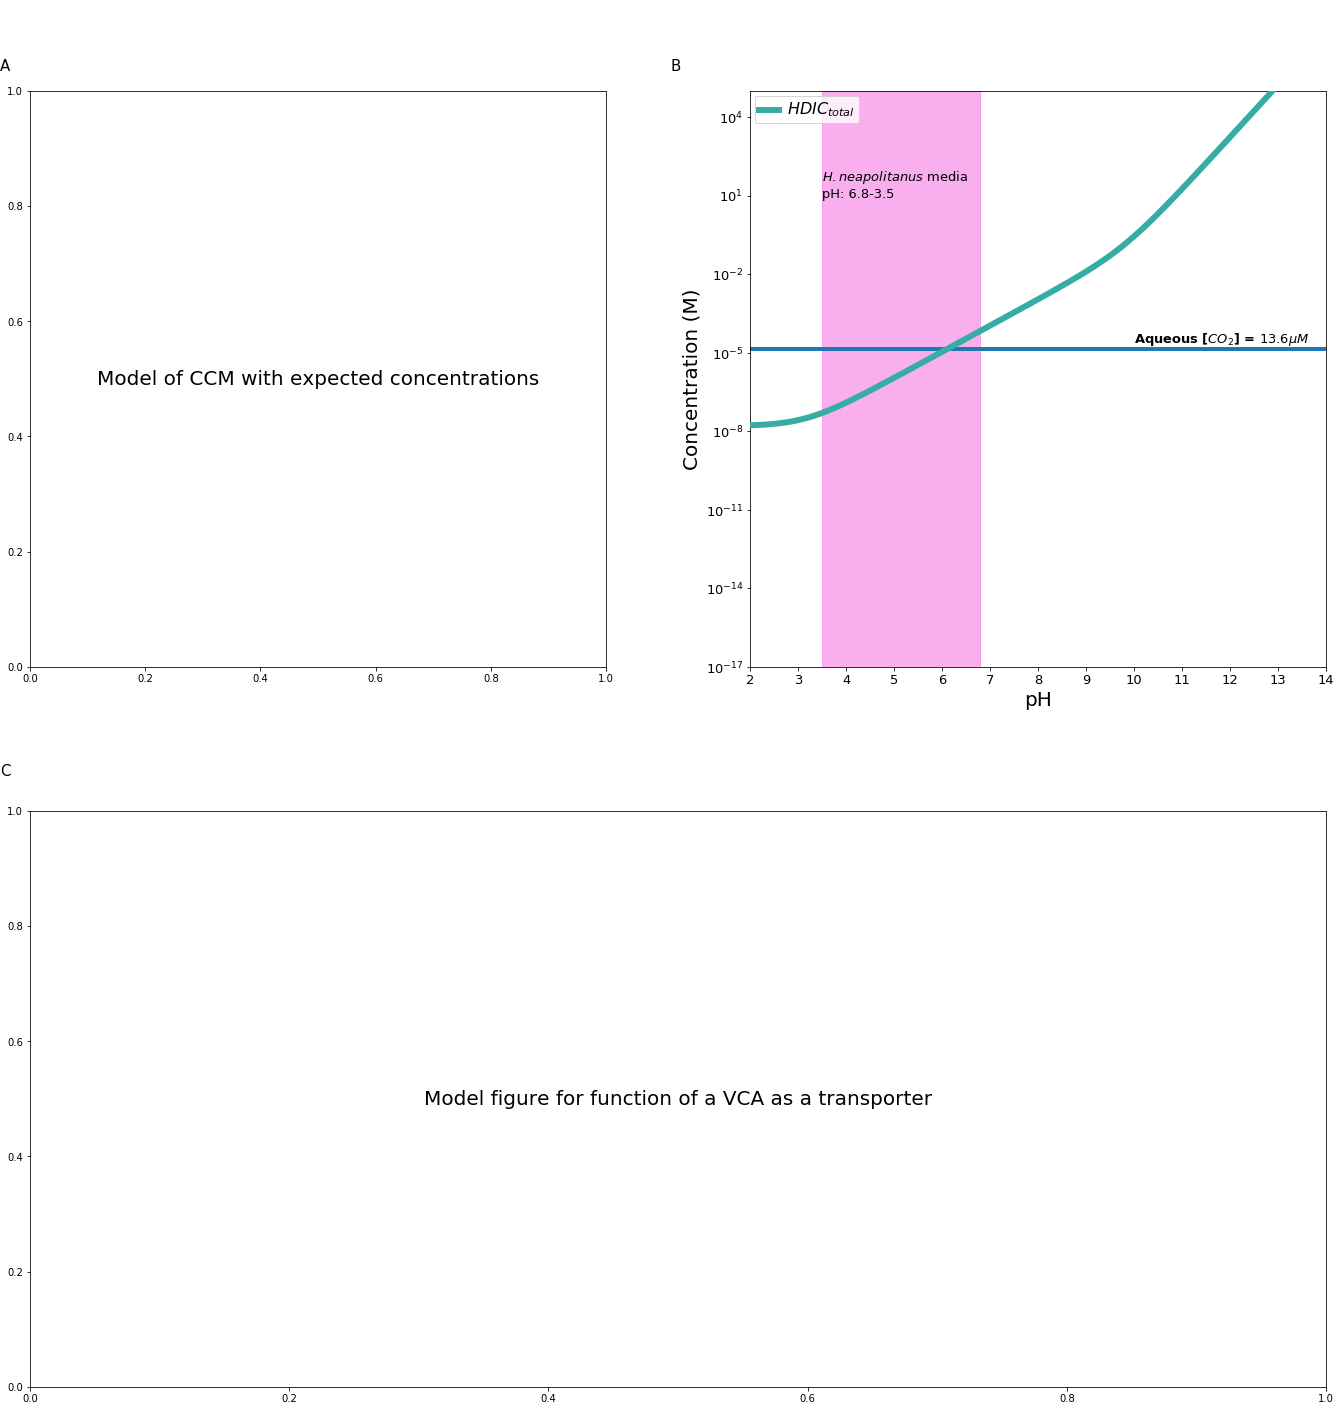

In [6]:
fig = plt.figure(figsize=(20,20),frameon=False)

panelA = fig.add_axes([0,0.5,0.4,0.4])
makePanelA(panelA)
plt.annotate('A',[0,0.95],xycoords='figure fraction',fontsize=15)


panelB = fig.add_axes([0.5,0.5,0.4,0.4])
makePanelB(panelB)
plt.annotate('B',[0.5,0.95],xycoords='figure fraction',fontsize=15)

panelC = fig.add_axes([0,0,0.9,0.4])
makePanelC(panelC)
plt.annotate('C',[0,.45],xycoords='figure fraction',fontsize=15)


plt.tight_layout()

plt.savefig('/Volumes/Shared/data/Jack/SavageLab/scripts/FigureMakingForBarseqDABPaper/fig1Draft.svg',
           format='svg',bbox_inches='tight')
plt.savefig('/Volumes/Shared/data/Jack/SavageLab/scripts/FigureMakingForBarseqDABPaper/fig1Draft.png',
           format='png',bbox_inches='tight')

**Figure 1: An acidophile is expected to prefer a VCA to bicarbonate transporter to power it's CCM.** *(a)* I havent made this panel yet, but I expect to put in a cell and a carboxysome and put in expected concentrations and show the roles of expected CCM components. *(b)* Expected concentrations of DIC species as a function of pH for a solution in equilibrium with atmosphere. In batch culture, *H. neapolitanus* acidifies it's media from a starting pH of 6.8 to a final pH of 3. for the majority of this range, the concentration of disolved CO2 is expected to be higer than any other DIC component. *(c)* I havent made this panel yet, but I expect to put ina model for how a VCA could function and/or how this would yield net Ci transport.